In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
# Define the VGG11 Model
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            # Conv(1, 64, 3, 1, 1) - BatchNorm(64) - ReLU - MaxPool(2, 2)
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(64, 128, 3, 1, 1) - BatchNorm(128) - ReLU - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - ReLU
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - ReLU - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - ReLU - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Linear(512, 4096) - ReLU - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Linear(4096, 4096) - ReLU - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            # Linear(4096, 10)
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

In [4]:
# Data Preprocessing and Loading
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with MNIST mean and std
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
# Initialize the Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG11().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [5]:
num_epochs = 20

# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * data.size(0)  # Multiply by batch size

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train

    # Record training metrics
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)  # Multiply by batch size
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test

    # Record test metrics
    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

# Save the Trained Model
torch.save(model.state_dict(), 'vgg11_mnist.pth')

Epoch [1/20] Train Loss: 0.1271, Train Acc: 96.14% Test Loss: 0.0364, Test Acc: 98.80%
Epoch [2/20] Train Loss: 0.0378, Train Acc: 98.94% Test Loss: 0.0225, Test Acc: 99.34%
Epoch [3/20] Train Loss: 0.0253, Train Acc: 99.30% Test Loss: 0.0302, Test Acc: 99.06%
Epoch [4/20] Train Loss: 0.0205, Train Acc: 99.41% Test Loss: 0.0259, Test Acc: 99.21%
Epoch [5/20] Train Loss: 0.0154, Train Acc: 99.55% Test Loss: 0.0455, Test Acc: 98.81%
Epoch [6/20] Train Loss: 0.0122, Train Acc: 99.66% Test Loss: 0.0193, Test Acc: 99.44%
Epoch [7/20] Train Loss: 0.0088, Train Acc: 99.74% Test Loss: 0.0247, Test Acc: 99.30%
Epoch [8/20] Train Loss: 0.0089, Train Acc: 99.73% Test Loss: 0.0202, Test Acc: 99.42%
Epoch [9/20] Train Loss: 0.0084, Train Acc: 99.74% Test Loss: 0.0289, Test Acc: 99.27%
Epoch [10/20] Train Loss: 0.0067, Train Acc: 99.81% Test Loss: 0.0207, Test Acc: 99.36%
Epoch [11/20] Train Loss: 0.0049, Train Acc: 99.87% Test Loss: 0.0517, Test Acc: 99.02%
Epoch [12/20] Train Loss: 0.0056, Train A

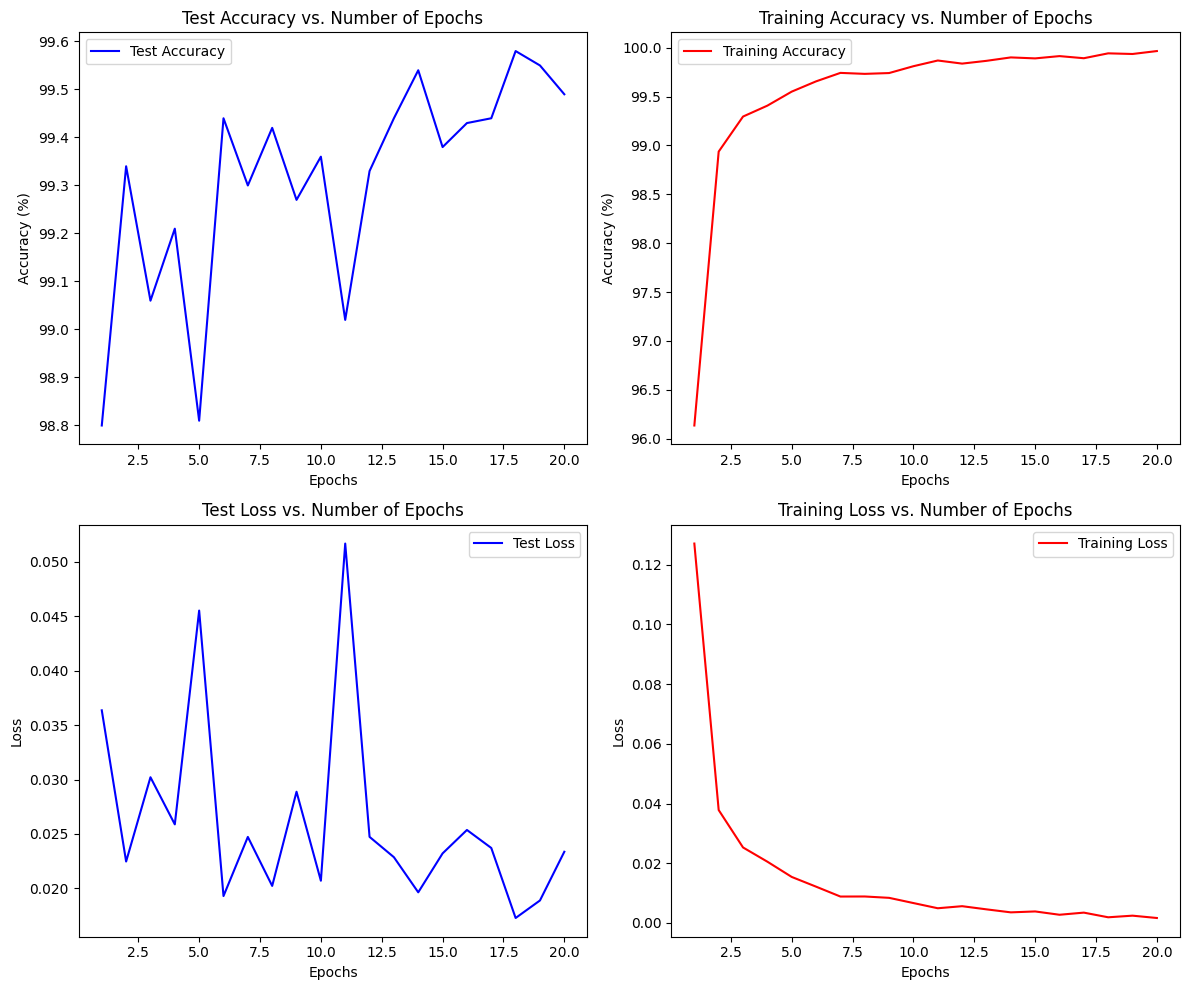

In [6]:
# Plotting the metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12,10))

# Test accuracy vs. number of epochs
plt.subplot(2,2,1)
plt.plot(epochs, test_accuracies, 'b', label='Test Accuracy')
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Training accuracy vs. number of epochs
plt.subplot(2,2,2)
plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Test loss vs. number of epochs
plt.subplot(2,2,3)
plt.plot(epochs, test_losses, 'b', label='Test Loss')
plt.title('Test Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Training loss vs. number of epochs
plt.subplot(2,2,4)
plt.plot(epochs, train_losses, 'r', label='Training Loss')
plt.title('Training Loss vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 3a. Test accuracy vs type of flip

In [11]:
horizontal_flip_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

vertical_flip_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [12]:
test_dataset_hflip = datasets.MNIST(root='./data', train=False, transform=horizontal_flip_transform, download=True)
test_loader_hflip = DataLoader(test_dataset_hflip, batch_size=1000, shuffle=False)

test_dataset_vflip = datasets.MNIST(root='./data', train=False, transform=vertical_flip_transform, download=True)
test_loader_vflip = DataLoader(test_dataset_vflip, batch_size=1000, shuffle=False)


In [13]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [15]:
# Evaluate on horizontally flipped images
accuracy_hflip = evaluate_model(model, test_loader_hflip)
print(f'Test Accuracy with Horizontal Flip: {accuracy_hflip:.2f}%')

# Evaluate on vertically flipped images
accuracy_vflip = evaluate_model(model, test_loader_vflip)
print(f'Test Accuracy with Vertical Flip: {accuracy_vflip:.2f}%')


Test Accuracy with Horizontal Flip: 40.04%
Test Accuracy with Vertical Flip: 45.19%


# 3b. Test accuracy vs Gaussian noise

In [16]:
def add_gaussian_noise(variance):
    std_dev = variance ** 0.5
    noise_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + std_dev * torch.randn_like(x)),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    return noise_transform


In [18]:
variances = [0.01, 0.1, 1]
for var in variances:
    noise_transform = add_gaussian_noise(var)
    noisy_test_dataset = datasets.MNIST(
        root='./data', train=False, transform=noise_transform, download=True)
    noisy_test_loader = DataLoader(noisy_test_dataset, batch_size=1000, shuffle=False)

    accuracy_noisy = evaluate_model(model, noisy_test_loader)
    print(f'Test Accuracy with Gaussian Noise Variance {var}: {accuracy_noisy:.2f}%')


Test Accuracy with Gaussian Noise Variance 0.01: 97.70%
Test Accuracy with Gaussian Noise Variance 0.1: 34.72%
Test Accuracy with Gaussian Noise Variance 1: 9.74%


# 4. Data augmentation

In [19]:
# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(
        degrees=10,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
        shear=10
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


In [20]:
# Load the augmented training dataset
train_dataset_aug = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=64, shuffle=True)

In [21]:
# Test data transform remains the same
test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [22]:
model_aug = VGG11().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_aug.parameters(), lr=0.01, momentum=0.9)

In [23]:
num_epochs = 20

train_losses_aug = []
train_accuracies_aug = []
test_losses_aug = []
test_accuracies_aug = []

for epoch in range(1, num_epochs + 1):
    model_aug.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader_aug:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model_aug(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_losses_aug.append(epoch_train_loss)
    train_accuracies_aug.append(train_accuracy)

    # Evaluate on the original test set
    model_aug.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_aug(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    test_losses_aug.append(epoch_test_loss)
    test_accuracies_aug.append(test_accuracy)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


Epoch [1/20] Train Loss: 0.5268, Train Acc: 81.68% Test Loss: 0.1862, Test Acc: 94.12%
Epoch [2/20] Train Loss: 0.2369, Train Acc: 92.38% Test Loss: 0.1910, Test Acc: 93.55%
Epoch [3/20] Train Loss: 0.1996, Train Acc: 93.53% Test Loss: 0.1684, Test Acc: 94.37%
Epoch [4/20] Train Loss: 0.1763, Train Acc: 94.30% Test Loss: 0.1256, Test Acc: 95.57%
Epoch [5/20] Train Loss: 0.1639, Train Acc: 94.71% Test Loss: 0.1050, Test Acc: 96.40%
Epoch [6/20] Train Loss: 0.1532, Train Acc: 94.91% Test Loss: 0.1117, Test Acc: 96.26%
Epoch [7/20] Train Loss: 0.1457, Train Acc: 95.18% Test Loss: 0.0833, Test Acc: 97.28%
Epoch [8/20] Train Loss: 0.1351, Train Acc: 95.54% Test Loss: 0.1272, Test Acc: 95.46%
Epoch [9/20] Train Loss: 0.1304, Train Acc: 95.82% Test Loss: 0.0819, Test Acc: 97.53%
Epoch [10/20] Train Loss: 0.1293, Train Acc: 95.73% Test Loss: 0.0922, Test Acc: 97.03%
Epoch [11/20] Train Loss: 0.1244, Train Acc: 95.94% Test Loss: 0.1058, Test Acc: 96.50%
Epoch [12/20] Train Loss: 0.1212, Train A

# 5. Adadelta and Adam optimizer

In [40]:
# Initialize the model
model_adadelta = VGG11().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the AdaDelta optimizer
optimizer_adadelta = optim.Adadelta(model_adadelta.parameters(), lr=1.0)


In [41]:
num_epochs = 20

# Lists to store metrics
train_losses_adadelta = []
test_losses_adadelta = []
train_accuracies_adadelta = []
test_accuracies_adadelta = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    model_adadelta.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer_adadelta.zero_grad()
        outputs = model_adadelta(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer_adadelta.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_losses_adadelta.append(epoch_train_loss)
    train_accuracies_adadelta.append(train_accuracy)

    # Evaluation phase
    model_adadelta.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_adadelta(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    test_losses_adadelta.append(epoch_test_loss)
    test_accuracies_adadelta.append(test_accuracy)

    print(f'AdaDelta Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


AdaDelta Epoch [1/20] Train Loss: 0.7918, Train Acc: 68.28% Test Loss: 0.0720, Test Acc: 98.19%
AdaDelta Epoch [2/20] Train Loss: 0.0943, Train Acc: 97.74% Test Loss: 0.0702, Test Acc: 97.97%
AdaDelta Epoch [3/20] Train Loss: 0.0649, Train Acc: 98.45% Test Loss: 0.0306, Test Acc: 99.23%
AdaDelta Epoch [4/20] Train Loss: 0.0518, Train Acc: 98.81% Test Loss: 0.0405, Test Acc: 99.00%
AdaDelta Epoch [5/20] Train Loss: 0.0414, Train Acc: 98.99% Test Loss: 0.0577, Test Acc: 98.89%
AdaDelta Epoch [6/20] Train Loss: 0.0364, Train Acc: 99.19% Test Loss: 0.0307, Test Acc: 99.27%
AdaDelta Epoch [7/20] Train Loss: 0.0283, Train Acc: 99.37% Test Loss: 0.0488, Test Acc: 98.99%
AdaDelta Epoch [8/20] Train Loss: 0.0266, Train Acc: 99.37% Test Loss: 0.0481, Test Acc: 98.98%
AdaDelta Epoch [9/20] Train Loss: 0.0235, Train Acc: 99.47% Test Loss: 0.0319, Test Acc: 99.34%
AdaDelta Epoch [10/20] Train Loss: 0.0207, Train Acc: 99.53% Test Loss: 0.0391, Test Acc: 99.28%
AdaDelta Epoch [11/20] Train Loss: 0.02

In [26]:
# Initialize the model
model_adam = VGG11().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the Adam optimizer
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)


In [27]:
# Lists to store metrics
train_losses_adam = []
test_losses_adam = []
train_accuracies_adam = []
test_accuracies_adam = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    model_adam.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer_adam.zero_grad()
        outputs = model_adam(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer_adam.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_losses_adam.append(epoch_train_loss)
    train_accuracies_adam.append(train_accuracy)

    # Evaluation phase
    model_adam.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_adam(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    test_losses_adam.append(epoch_test_loss)
    test_accuracies_adam.append(test_accuracy)

    print(f'Adam Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


Adam Epoch [1/20] Train Loss: 0.4273, Train Acc: 85.21% Test Loss: 0.0909, Test Acc: 98.05%
Adam Epoch [2/20] Train Loss: 0.0980, Train Acc: 97.75% Test Loss: 0.0827, Test Acc: 98.34%
Adam Epoch [3/20] Train Loss: 0.0853, Train Acc: 98.25% Test Loss: 0.1107, Test Acc: 98.36%
Adam Epoch [4/20] Train Loss: 0.0855, Train Acc: 98.34% Test Loss: 0.0366, Test Acc: 99.12%
Adam Epoch [5/20] Train Loss: 0.0517, Train Acc: 98.88% Test Loss: 0.0510, Test Acc: 98.86%
Adam Epoch [6/20] Train Loss: 0.0482, Train Acc: 98.98% Test Loss: 0.0444, Test Acc: 98.95%
Adam Epoch [7/20] Train Loss: 0.0550, Train Acc: 98.96% Test Loss: 0.0415, Test Acc: 99.00%
Adam Epoch [8/20] Train Loss: 0.0367, Train Acc: 99.27% Test Loss: 0.0407, Test Acc: 99.29%
Adam Epoch [9/20] Train Loss: 0.0428, Train Acc: 99.11% Test Loss: 0.0364, Test Acc: 99.14%
Adam Epoch [10/20] Train Loss: 0.0270, Train Acc: 99.38% Test Loss: 0.0377, Test Acc: 99.26%
Adam Epoch [11/20] Train Loss: 0.0251, Train Acc: 99.44% Test Loss: 0.0295, Tes

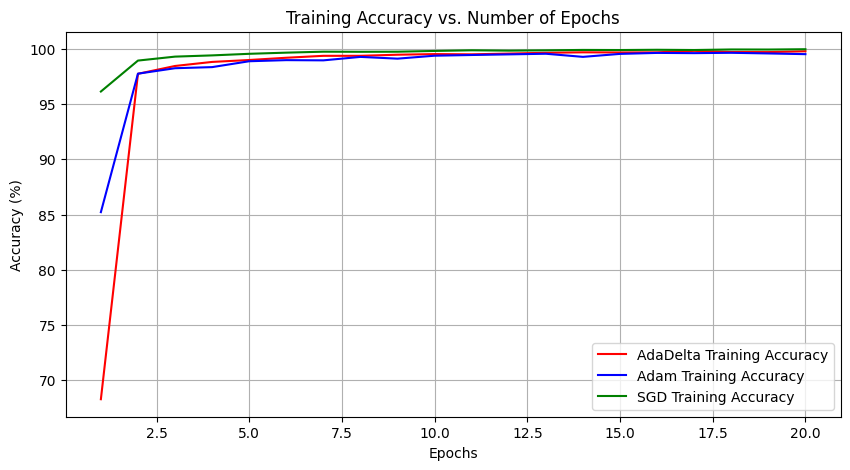

In [42]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies_adadelta, 'r-', label='AdaDelta Training Accuracy')
plt.plot(epochs, train_accuracies_adam, 'b-', label='Adam Training Accuracy')
plt.plot(epochs, train_accuracies, 'g-', label='SGD Training Accuracy')

plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


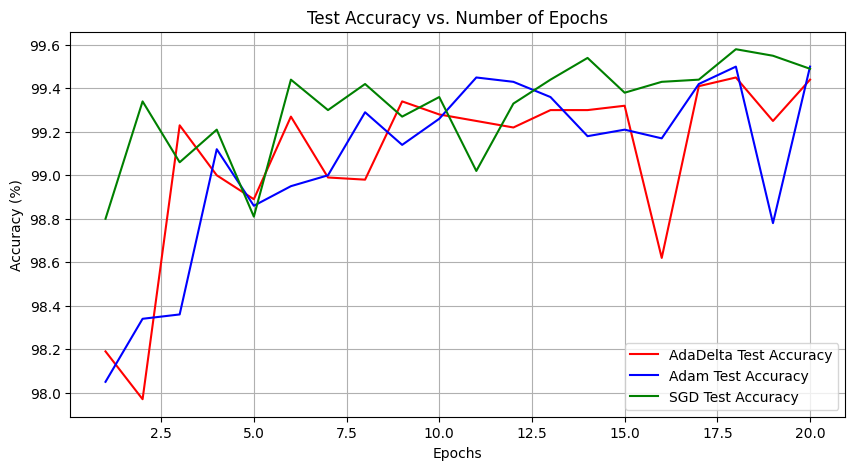

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies_adadelta, 'r-', label='AdaDelta Test Accuracy')
plt.plot(epochs, test_accuracies_adam, 'b-', label='Adam Test Accuracy')
plt.plot(epochs, test_accuracies, 'g-', label='SGD Test Accuracy')

plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# 6. Sigmoid activation function

In [30]:
class VGG11_Sigmoid(nn.Module):
    def __init__(self):
        super(VGG11_Sigmoid, self).__init__()
        self.features = nn.Sequential(
            # Conv(1, 64, 3, 1, 1) - BatchNorm(64) - Sigmoid - MaxPool(2, 2)
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(64, 128, 3, 1, 1) - BatchNorm(128) - Sigmoid - MaxPool(2, 2)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(128, 256, 3, 1, 1) - BatchNorm(256) - Sigmoid
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),

            # Conv(256, 256, 3, 1, 1) - BatchNorm(256) - Sigmoid - MaxPool(2, 2)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(256, 512, 3, 1, 1) - BatchNorm(512) - Sigmoid
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - Sigmoid - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - Sigmoid
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),

            # Conv(512, 512, 3, 1, 1) - BatchNorm(512) - Sigmoid - MaxPool(2, 2)
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Linear(512, 4096) - Sigmoid - Dropout(0.5)
            nn.Linear(512, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),

            # Linear(4096, 4096) - Sigmoid - Dropout(0.5)
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(0.5),

            # Linear(4096, 10)
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


In [31]:
# Initialize the model
model_sigmoid = VGG11_Sigmoid().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.01, momentum=0.9)

In [32]:
num_epochs = 20

# Lists to store metrics
train_losses_sigmoid = []
test_losses_sigmoid = []
train_accuracies_sigmoid = []
test_accuracies_sigmoid = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    model_sigmoid.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model_sigmoid(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_losses_sigmoid.append(epoch_train_loss)
    train_accuracies_sigmoid.append(train_accuracy)

    # Evaluation phase
    model_sigmoid.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_sigmoid(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    test_losses_sigmoid.append(epoch_test_loss)
    test_accuracies_sigmoid.append(test_accuracy)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


Epoch [1/20] Train Loss: 1.7578, Train Acc: 33.42% Test Loss: 5.8587, Test Acc: 14.34%
Epoch [2/20] Train Loss: 0.3500, Train Acc: 90.18% Test Loss: 2.4637, Test Acc: 41.06%
Epoch [3/20] Train Loss: 0.1328, Train Acc: 96.59% Test Loss: 0.1812, Test Acc: 95.11%
Epoch [4/20] Train Loss: 0.0836, Train Acc: 97.86% Test Loss: 0.2747, Test Acc: 91.68%
Epoch [5/20] Train Loss: 0.0621, Train Acc: 98.43% Test Loss: 0.0603, Test Acc: 98.52%
Epoch [6/20] Train Loss: 0.0519, Train Acc: 98.65% Test Loss: 0.1510, Test Acc: 96.14%
Epoch [7/20] Train Loss: 0.0426, Train Acc: 98.79% Test Loss: 0.0659, Test Acc: 98.42%
Epoch [8/20] Train Loss: 0.0363, Train Acc: 99.00% Test Loss: 0.0984, Test Acc: 97.36%
Epoch [9/20] Train Loss: 0.0333, Train Acc: 99.09% Test Loss: 0.1924, Test Acc: 94.55%
Epoch [10/20] Train Loss: 0.0275, Train Acc: 99.26% Test Loss: 0.2083, Test Acc: 94.23%
Epoch [11/20] Train Loss: 0.0220, Train Acc: 99.39% Test Loss: 0.0847, Test Acc: 97.56%
Epoch [12/20] Train Loss: 0.0203, Train A

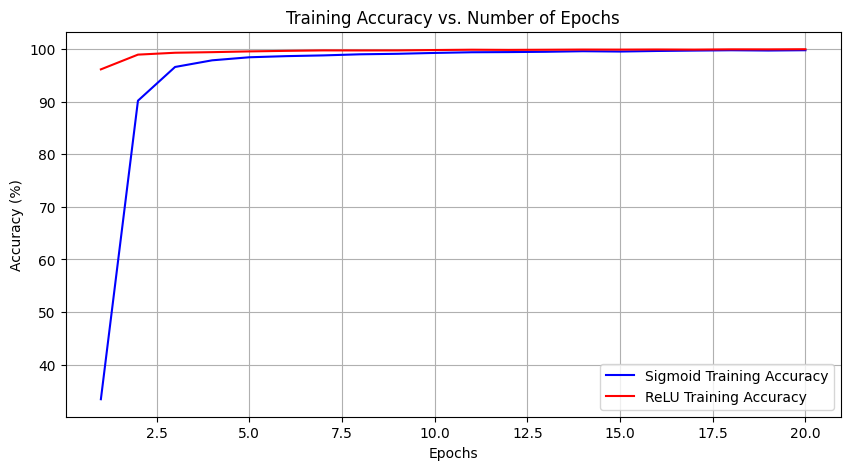

In [45]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies_sigmoid, 'b-', label='Sigmoid Training Accuracy')
plt.plot(epochs, train_accuracies, 'r-', label='ReLU Training Accuracy')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


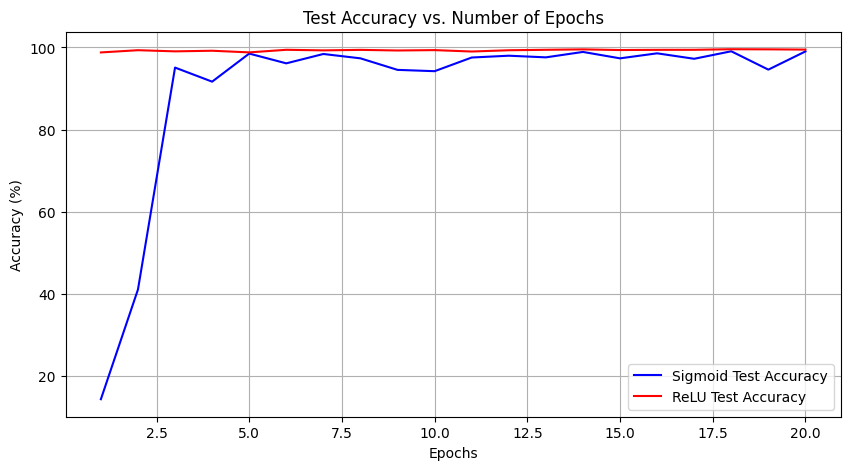

In [34]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies_sigmoid, 'b-', label='Sigmoid Test Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='ReLU Test Accuracy')
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


# 7. Removing Dropout from the CNN

In [35]:
class VGG11_NoDropout(nn.Module):
    def __init__(self):
        super(VGG11_NoDropout, self).__init__()
        self.features = nn.Sequential(
            # Feature layers remain the same
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            # Removed Dropout layers
            nn.Linear(512, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


In [36]:
# Initialize the model without Dropout
model_no_dropout = VGG11_NoDropout().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_no_dropout.parameters(), lr=0.01, momentum=0.9)

In [37]:
num_epochs = 20

# Lists to store metrics
train_losses_no_dropout = []
test_losses_no_dropout = []
train_accuracies_no_dropout = []
test_accuracies_no_dropout = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    model_no_dropout.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model_no_dropout(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()

    epoch_train_loss = running_loss / total_train
    train_accuracy = 100 * correct_train / total_train
    train_losses_no_dropout.append(epoch_train_loss)
    train_accuracies_no_dropout.append(train_accuracy)

    # Evaluation phase
    model_no_dropout.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model_no_dropout(data)
            loss = criterion(outputs, target)

            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += target.size(0)
            correct_test += (predicted == target).sum().item()

    epoch_test_loss = test_loss / total_test
    test_accuracy = 100 * correct_test / total_test
    test_losses_no_dropout.append(epoch_test_loss)
    test_accuracies_no_dropout.append(test_accuracy)

    print(f'Epoch [{epoch}/{num_epochs}] '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% '
          f'Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

Epoch [1/20] Train Loss: 0.1091, Train Acc: 96.67% Test Loss: 0.0384, Test Acc: 98.91%
Epoch [2/20] Train Loss: 0.0337, Train Acc: 98.97% Test Loss: 0.0274, Test Acc: 99.14%
Epoch [3/20] Train Loss: 0.0221, Train Acc: 99.33% Test Loss: 0.0629, Test Acc: 98.28%
Epoch [4/20] Train Loss: 0.0172, Train Acc: 99.49% Test Loss: 0.0222, Test Acc: 99.29%
Epoch [5/20] Train Loss: 0.0134, Train Acc: 99.57% Test Loss: 0.0293, Test Acc: 99.11%
Epoch [6/20] Train Loss: 0.0105, Train Acc: 99.68% Test Loss: 0.0219, Test Acc: 99.31%
Epoch [7/20] Train Loss: 0.0090, Train Acc: 99.70% Test Loss: 0.0386, Test Acc: 98.91%
Epoch [8/20] Train Loss: 0.0088, Train Acc: 99.72% Test Loss: 0.0226, Test Acc: 99.45%
Epoch [9/20] Train Loss: 0.0050, Train Acc: 99.86% Test Loss: 0.0194, Test Acc: 99.48%
Epoch [10/20] Train Loss: 0.0041, Train Acc: 99.88% Test Loss: 0.0248, Test Acc: 99.35%
Epoch [11/20] Train Loss: 0.0036, Train Acc: 99.90% Test Loss: 0.0231, Test Acc: 99.40%
Epoch [12/20] Train Loss: 0.0033, Train A

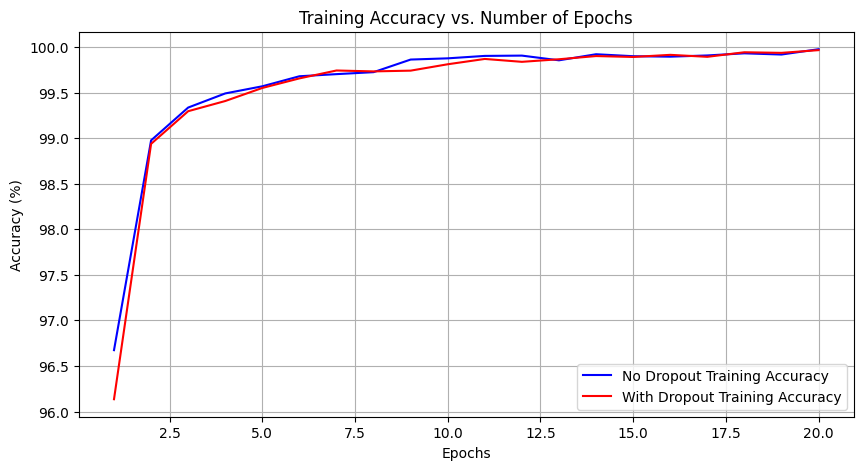

In [38]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies_no_dropout, 'b-', label='No Dropout Training Accuracy')
plt.plot(epochs, train_accuracies, 'r-', label='With Dropout Training Accuracy')
plt.title('Training Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


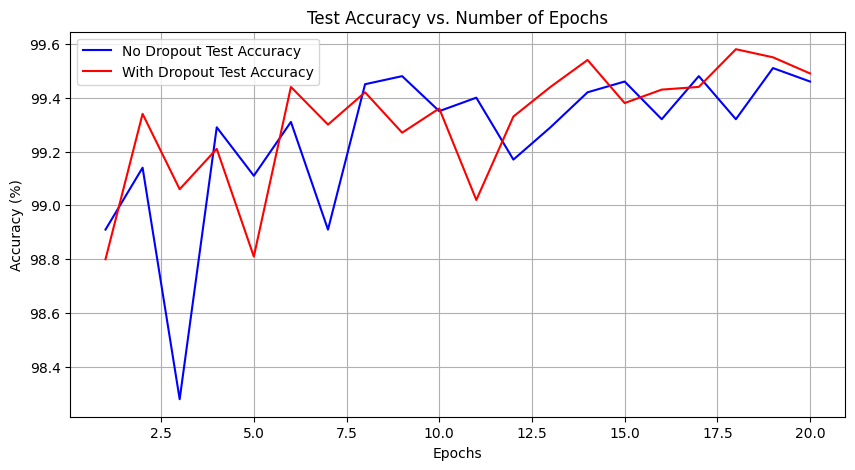

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, test_accuracies_no_dropout, 'b-', label='No Dropout Test Accuracy')
plt.plot(epochs, test_accuracies, 'r-', label='With Dropout Test Accuracy')
plt.title('Test Accuracy vs. Number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
